In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys
sys.path.append('../py_modules')
import module_plt_params_de
import module_denrichr_v02 as denrichr
import imp

# load data
df = pd.read_table("mitoproteomics_acute_preprocessed.txt")
rnaseq = pd.read_table("./repos/GSE104897/bsn_rnaseq.txt")
tca_genes = pd.read_table("repos/tca_etc_candidates_figure_210131.csv", sep=';')
tca_genes = [x.capitalize() for x in tca_genes.loc[tca_genes.group=='tca', 'gene'].tolist()]

In [7]:
# mean expression and mito proteins
df['expression'] = [df.loc[i, ['mean_log2lfqctrl', 'mean_log2lfqeae']].mean() for i in range(len(df))]
df = df.loc[df.mitocarta == 1, :]

# merge proteomics and rna-seq data
merged = df.merge(rnaseq, right_index=True, left_on='gene', how='left')
merged = merged.loc[:, ['log2fc', 'log2FoldChange', 'gene', 'expression']]
merged.columns = ['fc_p', 'fc_t', 'gene', 'expr']

merged = merged.sort_values(by='fc_p')
merged['rank_p'] = range(len(merged))

merged = merged.sort_values(by='fc_t')
merged['rank_t'] = range(len(merged))

merged = merged.dropna()
merged.index = range(len(merged))

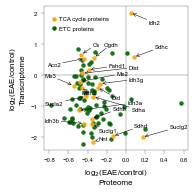

In [8]:
import nezzworker.nezzworker as nezzworker
tca_genes = [x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Citric acid cycle (TCA cycle)'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]
ret_genes = [x.capitalize() for x in nezzworker.getgenesets('custom_all').run()['Respiratory electron transport'] if x.capitalize() in df.loc[df.mitocarta == 1, 'gene'].tolist()]


fig = plt.figure(figsize=(2,2))
ax = fig.add_axes([0,0,1,1])

ax.scatter('fc_p', 'fc_t', data=merged.loc[merged.gene.isin(ret_genes)], s=20, lw=0, color='darkgreen', alpha=.9)
ax.scatter('fc_p', 'fc_t', data=merged.loc[merged.gene.isin(tca_genes)], s=20, lw=0, color='orange', alpha=.9)
ax.axhline(0, lw=.25, zorder=-1)
ax.axvline(0, lw=.25,zorder=-1)
ax.set_ylabel('log$_{2}$(EAE/control)\nTranscriptome')
ax.set_xlabel('log$_{2}$(EAE/control)\nProteome')

ax.scatter(-.75, 1.8, s=20, lw=0, color='orange')
ax.text(-.7, 1.8, 'TCA cycle proteins', ha='left', va='center', fontsize=6)
ax.scatter(-.75, 1.5, s=20, lw=0, color='darkgreen')
ax.text(-.7, 1.5, 'ETC proteins', ha='left', va='center', fontsize=6)

TEXTS = []
for i in range(len(tca_genes)):
    if tca_genes[i] in merged.gene.tolist():
        x = merged.loc[merged.gene==tca_genes[int(i)], 'fc_p'].values[0]
        y = merged.loc[merged.gene==tca_genes[int(i)], 'fc_t'].values[0]
        text = tca_genes[i]
        TEXTS.append(ax.text(x, y, text, color='0', fontsize=6, va='center', ha='left'))

from adjustText import adjust_text
adjust_text(
    TEXTS, 
    expand_points=(4,4),
    force_text=(.1,.1),
    force_points=(.1,.1),
    arrowprops=dict(
        arrowstyle="->",
        color='0', 
        lw=.5
    ),
    ax=fig.axes[0]
)

fig.savefig('output/mitoproteomics_tca_ret_ptcorrel.pdf', transparent=True, dpi = 900, bbox_inches="tight", pad_inches=.05)